# SENTIMENT CLASSIFICATION ANALYSIS USING WORDLIST CLASSIFIER AND NAIVE BAYES CLASSIFIER
Here in this analysis,I am doing the comparison between wordlist classifier and Naive Bayes classifier for sentiment classification using the measurements **Precision**, **Recall**, **Accuracy** and **F-1 Score**. The data used for the analysis is `movie_reviews` from `nltk.corpus`

In [1]:
#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [2]:
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [3]:
random.seed(133)#seeding the data so that the results won't change on multiple run on the cell
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['some', 'critics', ',', 'including', 'siskel', '&', ...], 'pos')


### WORDLIST CLASSIFIER

From nltk.corpus stopwords module has been imported and a function ```normalise
``` has been created, which lowers each word in the wordlist and removes the common stopwords in the english language

In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
# function for normalising and filtering the training and testing data 
def normalise(wordlist):
    lowered=[word.lower() for word in wordlist] 
    filtered=[word for word in lowered if word.isalpha() and word not in stop]
    return filtered

`training_norm` and `testing_norm`, which are list of tuple containing frequency distribution and its correponding Label (ie positive or negative review) is created using list comprehension and then all the frequency distribution curresponding to positive and negative reviews are summed up. Finally, We finds the content words corresponding to positive and negative feedback by finding out the difference in frequencies of in which they occure in the training sample. The code is given below.

In [5]:
training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

#creates instances of FreqDist class
pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

# positive and negative comments are classified into different frequency distribution using the lable
for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist
        
#the differnce of frequency of appearence of each word in the documents are classified into pos_diff and neg_diff
pos_diff = pos_freq_dist - neg_freq_dist
neg_diff = neg_freq_dist - pos_freq_dist

pos_wordlist=[i[0] for i in pos_diff.most_common(10)]
neg_wordlist=[i[0] for i in neg_diff.most_common(10)]
print('Most common positive words are {}'.format(pos_wordlist))
print('Most common negative words are {}'.format(neg_wordlist))

Most common positive words are ['film', 'life', 'also', 'well', 'great', 'many', 'best', 'world', 'story', 'one']
Most common negative words are ['movie', 'bad', 'get', 'plot', 'even', 'worst', 'nothing', 'script', 'supposed', 'boring']


If we had only taken the frequency count in which the words appear in positive and negative comments,then there are many words like movie, films etc. which appears frequently in both the lists and it is not logical to classify the reviews based on this. So, taking frequency difference is the better way to identify the content words indicating positive and negative reviews because the way we use language to express different emotions are different. Hence, the number of times one will use a perticular word in a postive comment will be most probably different from the number of words the person will use in a negative comment.


To generate a wordlist classifier class, `ClassifierI` parent class imported from `nltk.classify.api` and new method `classify` is defined. The method takes the frequency distribution of the words as the parameter and increment or decrement a counter with the frequency of each word, depending upon whether the word actually belongs to the positive wordlist or negative wordlist. In this classifier I have not considered the the words which doesn't belong to either positive or negative wordlist. One way is to randomly assign those words as either positive or negative and count the score, but since the value we count is the frequency of the occurance of that word and not +1 or -1 it might create an unnecessary weightage to either positive or negative review if the freqency of the word which is not in either list is so large. 

After creating the classifier class, and instance `WordlistClassifier` is created.

In [6]:
from nltk.classify.api import ClassifierI

#SimpleClassifier inherits ClassifierI(later used for `classify_many` method)
class SimpleClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

    def classify(self, doc): 
        #doc is a FreqDist
        score = 0
        
 #calculates the total score of the document by anlysing each review classification       
        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value
        
        return "neg" if score < 0 else "pos" 

     

    def labels(self): 
        return ("pos", "neg")


In [7]:
WordListClassifier = SimpleClassifier(pos_wordlist,neg_wordlist)# created an instance of the classifier
WordListClassifier.classify(FreqDist(training_norm[0][0])) # to check if the code is working as expected a frequency distribution is given to the classifier instance as a parameter

'pos'

To calculate the accuracy of the classifier `WordListClassifier` a function `classifier_evaluate` is generated. The `classifier_evaluate` takes in the classifer we created and the test_data as parameters. From the test_data the Frequency distribution and the label ('pos' or 'neg') is extracted. For each prediction by the classifier, the prediction is compared with the actual label and if both are same, counter `acc` is added by one.

The accuracy of the classifier is defined as $\frac{Number\thinspace  of \thinspace correct \thinspace predictions}{length \thinspace of \, data}$

In [8]:
def classifier_evaluate(cls, test_data):
    '''
    cls: an instance of a classifier object which has a classify method which returns "pos" or "neg"
    test_data: a list of pairs where each pair is a FreqDist rep of a doc and its label
  
    returns: float point number which is the accuracy of the classifier on the test data provided 
    '''
    acc = 0 #initiating counter
    docs,goldstandard=zip(*test_data) #to convert list of pair to pair of list
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1
    
    return acc / (len(test_data)) #returns the accuracy 

In [9]:
docs,goldstandard = zip(*testing_norm) # to seperate the frequency distribution and the label
predictions = WordListClassifier.classify_many(docs)
Accuracy1 = classifier_evaluate(WordListClassifier,testing_norm)
print('The accuracy of the above classifier is {}'.format(Accuracy1))

The accuracy of the above classifier is 0.6066666666666667


A `ConfusionMatrix` class is defined so that we can find out the counts of **True positive** , **False Negative** , **False Positive** and **True Negative** and finally calculate **Precision**, **Recall** and **f1** score. 

* $Precision\, (p)$ = $\frac{TP}{TP+FP}$ = fraction of relevant instances among the retrieved instances

* $Recall\, (r)$ = $\frac{TP}{TP+FN}$ =  fraction of relevant instances that were retrieved

* $f1\, score $ = $\frac{2\times p\times r}{p+r}$ = Harmonic mean of precision and recall

In [10]:
class ConfusionMatrix: #defining our own confusion matrix for this analysis
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
    
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
#counts total number of True positives, True Negatives, False positives and False Negatives        
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    
    def precision(self):#calculates precision
        p=0
        
        p = self.TP / (self.TP + self.FP)
    
        return p
  
    def recall(self):#calculates recall
        r=0
        
        r = self.TP/(self.TP + self.FN)
    
        return r
  
    def f1(self):#calculates f-1 score
        f1=0
        
        f1= 2*self.precision()*self.recall()/(self.precision()+self.recall())
        return f1 

An instance of confusion matrix `ConfusionMatrix_1` is made and the precision, recall and f1 score is calculated by calling the corresponding classes in the `ConfusionMatrix`. The prediction by the `WordListClassifier` and the actual label is passed to the confusion matrix as the parameters to calculate the scores.

In [11]:
ConfusionMatrix_1 = ConfusionMatrix(predictions,goldstandard) #instance of Confusion Matrix is generated
precision1 = ConfusionMatrix_1.precision()
recall1= ConfusionMatrix_1.recall()
f11= ConfusionMatrix_1.f1()

The Calculated Precision, Recall, f1 and accuracy is printed

In [12]:
print('The Precision of the classifier is {}'.format(ConfusionMatrix_1.precision()))
print( 'The recall of the classifier is {}'.format(ConfusionMatrix_1.recall()))
print('The f1 of the score the classifier is {}'.format(ConfusionMatrix_1.f1()))
print('The accuracy of the classifier is {}'.format(Accuracy1))

The Precision of the classifier is 0.5677966101694916
The recall of the classifier is 0.8933333333333333
The f1 of the score the classifier is 0.6943005181347152
The accuracy of the classifier is 0.6066666666666667


Accuracy alone is not a good measure to evaluate a classifier. For example, a classifier which always gives the output as positive review all the time and we are giving an input in which the data contains only 5% actual negative reviews, then, the accuracy of our classifier is 95%!. Accuracy could have been a good measure if the data was balanced. But in real world cases, mostly the data will be imbalanced and measuring only accuracy is not a good practice to evaluate the classifier.To tackle this problem we measure the above defined **precision**, **recall** and **f1-score**.

### NAIVE BAYES CLASSIFIER

From `nltk.classify` the ` NaiveBayesClassifier `is  imported and an instance of the imported class `nltk_NB` is created. The Naive Bayes Classifier is then trained using the training data and then the predictions are done on the test data using classify_many method of `NaiveBayesClassifier`

In [13]:
#imports NaiveBayesClassifier form nltk module and imports pandas
import nltk
from nltk.classify import NaiveBayesClassifier      
nltk_NB = NaiveBayesClassifier.train(training_norm)
import pandas as pd

An instance of `ConfusionMatrix` is used calculate the **precision**, **recall** , and **f1-score** of the prediction by the Naive Bayes Classifier. Here we are using the same confusion matrix which we created earlier for calculating the different scores, but we could have also used the inbulit functions in the naive bayes classifier to calculate the same. Both will give the same results.

In [14]:
nltk_NB_predictions =nltk_NB.classify_many(docs) # this is the prediction from the naive bayes classifier
ConfusionMatrix_2 = ConfusionMatrix(nltk_NB_predictions,goldstandard) #Using a different instance of confusion matrix to calculate the scores
precision2 =ConfusionMatrix_2.precision()
recall2 = ConfusionMatrix_2.recall()
f12 =ConfusionMatrix_2.f1()
print("The precision of the classifier is {}".format(precision2))
print("The recall of the classifier is {}".format(recall2))
print("The f1-score of the classifier is {}".format(f12))

The precision of the classifier is 0.6116910229645094
The recall of the classifier is 0.9766666666666667
The f1-score of the classifier is 0.7522464698331195


I have created a dictionary of results so that it can be easily converted to a pandas data frame and we can compare the wordlist classifier and Naive Bayes Classifier side by side

In [15]:
data = {'WordlistClassifier':[precision1,recall1,f11],'NaiveBayesClassifier':[precision2,recall2,f12] } # creating a dictionary of results from both the classifier
df = pd.DataFrame(data, index = ['Precision','Recall','f1-score']) #creates pandas dataframe to compare the scores
df

,WordlistClassifier,NaiveBayesClassifier
Precision,0.567797,0.611691
Recall,0.893333,0.976667
f1-score,0.694301,0.752246


Pandas data frame is used to make a comparision between `WordListClassifier` and the `nltk_NB` (Naive Bayes Classifier). Frome the generated data frame we can clearly observe that for all the parameters (Precision, Recall and F1-Score), NaiveBayesClassifier has the higher values, which clearly indicates that `NaiveBayesClassifier` is better compared to the created `WordListClassifier`

The highest improvement is result is seen in Recall which means that Naive bayes classifier does a good job in retrieving the relevent instances.

#### IMPACT OF WORDLIST LENGTH ON WORDLIST CLASSIFIER

To Understand the impact of the length of the wordlists on the wordlist classifier, I have created 90 instances of positive and negative word lists using a for-loop with its length increasing by 1 each time. The words are selected in such that the high frequncy words are selected initially and as the word list grows it selects words with comparatively less freqency.

In each loop, for each word lists the **accuracy**, **Precision** , **Recall** and **F1-score** is calculated using instance of `ConfusionMatrix`. The results for each are stored in different lists using .append() method.

In [16]:
#initialising lists so that scores for each loop can be held
list_accuracy = []
list_precision =[]
list_recall = []
list_f1 = []

for i in range(10,101):
  pos_wordlist =[j[0] for j in pos_diff.most_common(i)]
  neg_wordlist =[j[0] for j in neg_diff.most_common(i)]
  WordListClassifier = SimpleClassifier(pos_wordlist,neg_wordlist)#for each loop we have to initiate the instance of WordListClassifier since the lenth of wordlis is changing
  predictions1 = WordListClassifier.classify_many(docs)
  list_accuracy.append(classifier_evaluate(WordListClassifier,testing_norm))
  ConfusionMatrix_3 = ConfusionMatrix(predictions1,goldstandard)
  list_precision.append(ConfusionMatrix_3.precision())
  list_recall.append(ConfusionMatrix_3.recall())
  list_f1.append(ConfusionMatrix_3.f1())

In [17]:
wordlist_length = list(range(10,101))

Using matplotlib the graphs for Accuracpy, Precision, Recall and F1 score is plotted and the following results were observed

* The precision decreases from 0.59 to 0.54 and then increases again and maintains almost a steaddy value at 0.55 and then decreases again till 0.54

* There is no much change in the F1 score and is almost steady at 0.70

* The recall is increasing as the wordlist increases from 0.9 to 0.95


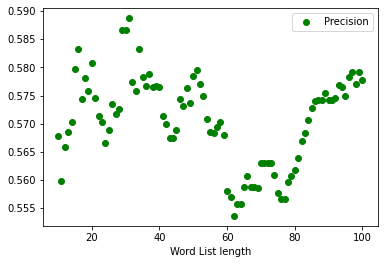

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
#plots precision vs wordlist_length  
plt.plot(wordlist_length,list_precision , 'go', label = 'Precision')
plt.xlabel('Word List length')
plt.legend()
plt.show()



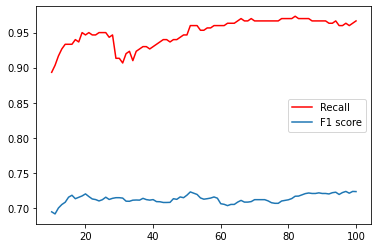

In [19]:
%matplotlib inline
#plots recall vs wordlist_length
plt.plot(wordlist_length,list_recall, 'r', label = 'Recall')
#plots F1 Score vs Wordlist_length
plt.plot(wordlist_length, list_f1, label = 'F1 score')
plt.legend()
plt.show()

### CONCLUSION

For a future work I will probably recommed Naive bayes classifier over word list classifier assuming we have large enough data available. In word list classifier we are not considering the probability of getting a  positive and negative review. We just build the classifier without considering it. But in Naive Bayes classifier we even consider the data distribution by calculating the probability of occurance of the data. Also from this analysis we can see that the scores are better for naive bayes classifier

So, hence I recommend Naive Bayes classifier over word list classifier